In [1]:
import layoutparser as lp

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2

# set up OCR

In [2]:
ocr_agent = lp.GCVAgent.with_credential("/home/lstm/.gcp/koreacaselaw-ffe91e33f191.json", languages = ['en', 'ko'])                                       

# read image

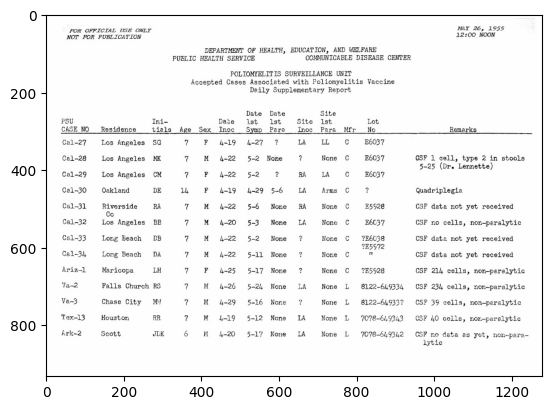

In [7]:
imagepath = '/home/lstm/Github/pdf2html/repo-layout-parser/examples/data/example-table.jpeg'
image = cv2.imread(imagepath)
plt.imshow(image)

# examine OCR response

In [8]:
res = ocr_agent.detect(image, return_response=True)
# Alternative
# res = ocr_agent.detect(imagepath, return_response=True)

In [12]:
dir(res)

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'ParseFromString',
 'RegisterExtension',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'UnknownFields',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_extensions_by_name',
 '_extensions_by_number',
 'context',
 'crop_hints_annotation',
 'error',
 'face_annotations',


# get text

In [35]:
texts = ocr_agent.gather_text_annotations(res)  # GCV automatically determines aggregation level
    # collect all the texts without coordinates

print(dir(lp.GCVFeatureType))
layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)  # get full hierachical otuput
    # collect all the layout elements of the `WORD` level, WIT H COORDINATES

['BLOCK', 'PAGE', 'PARA', 'SYMBOL', 'WORD', '__class__', '__doc__', '__members__', '__module__']


# visualize

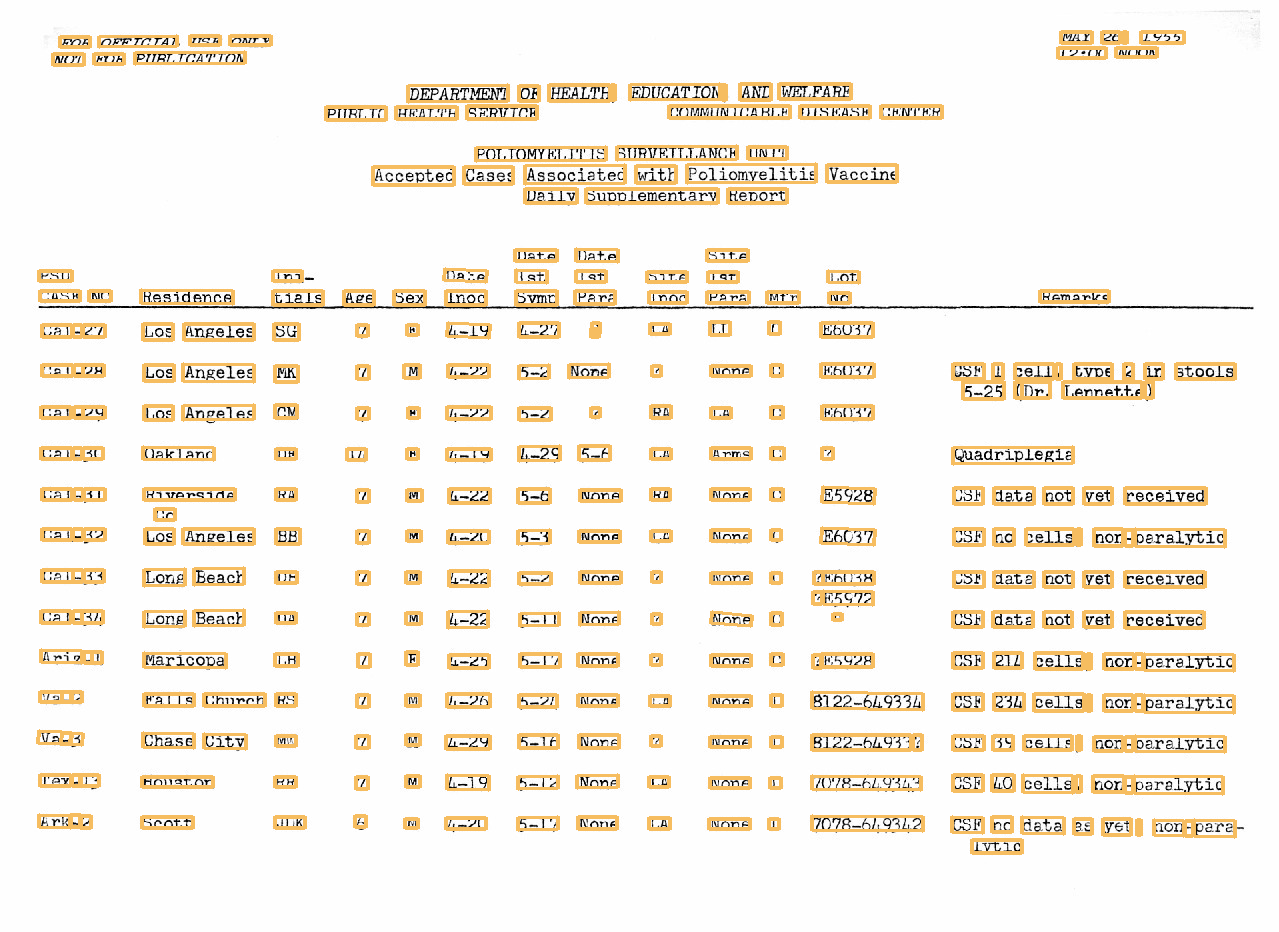

In [42]:
lp.draw_box(canvas=image, layout=layout)

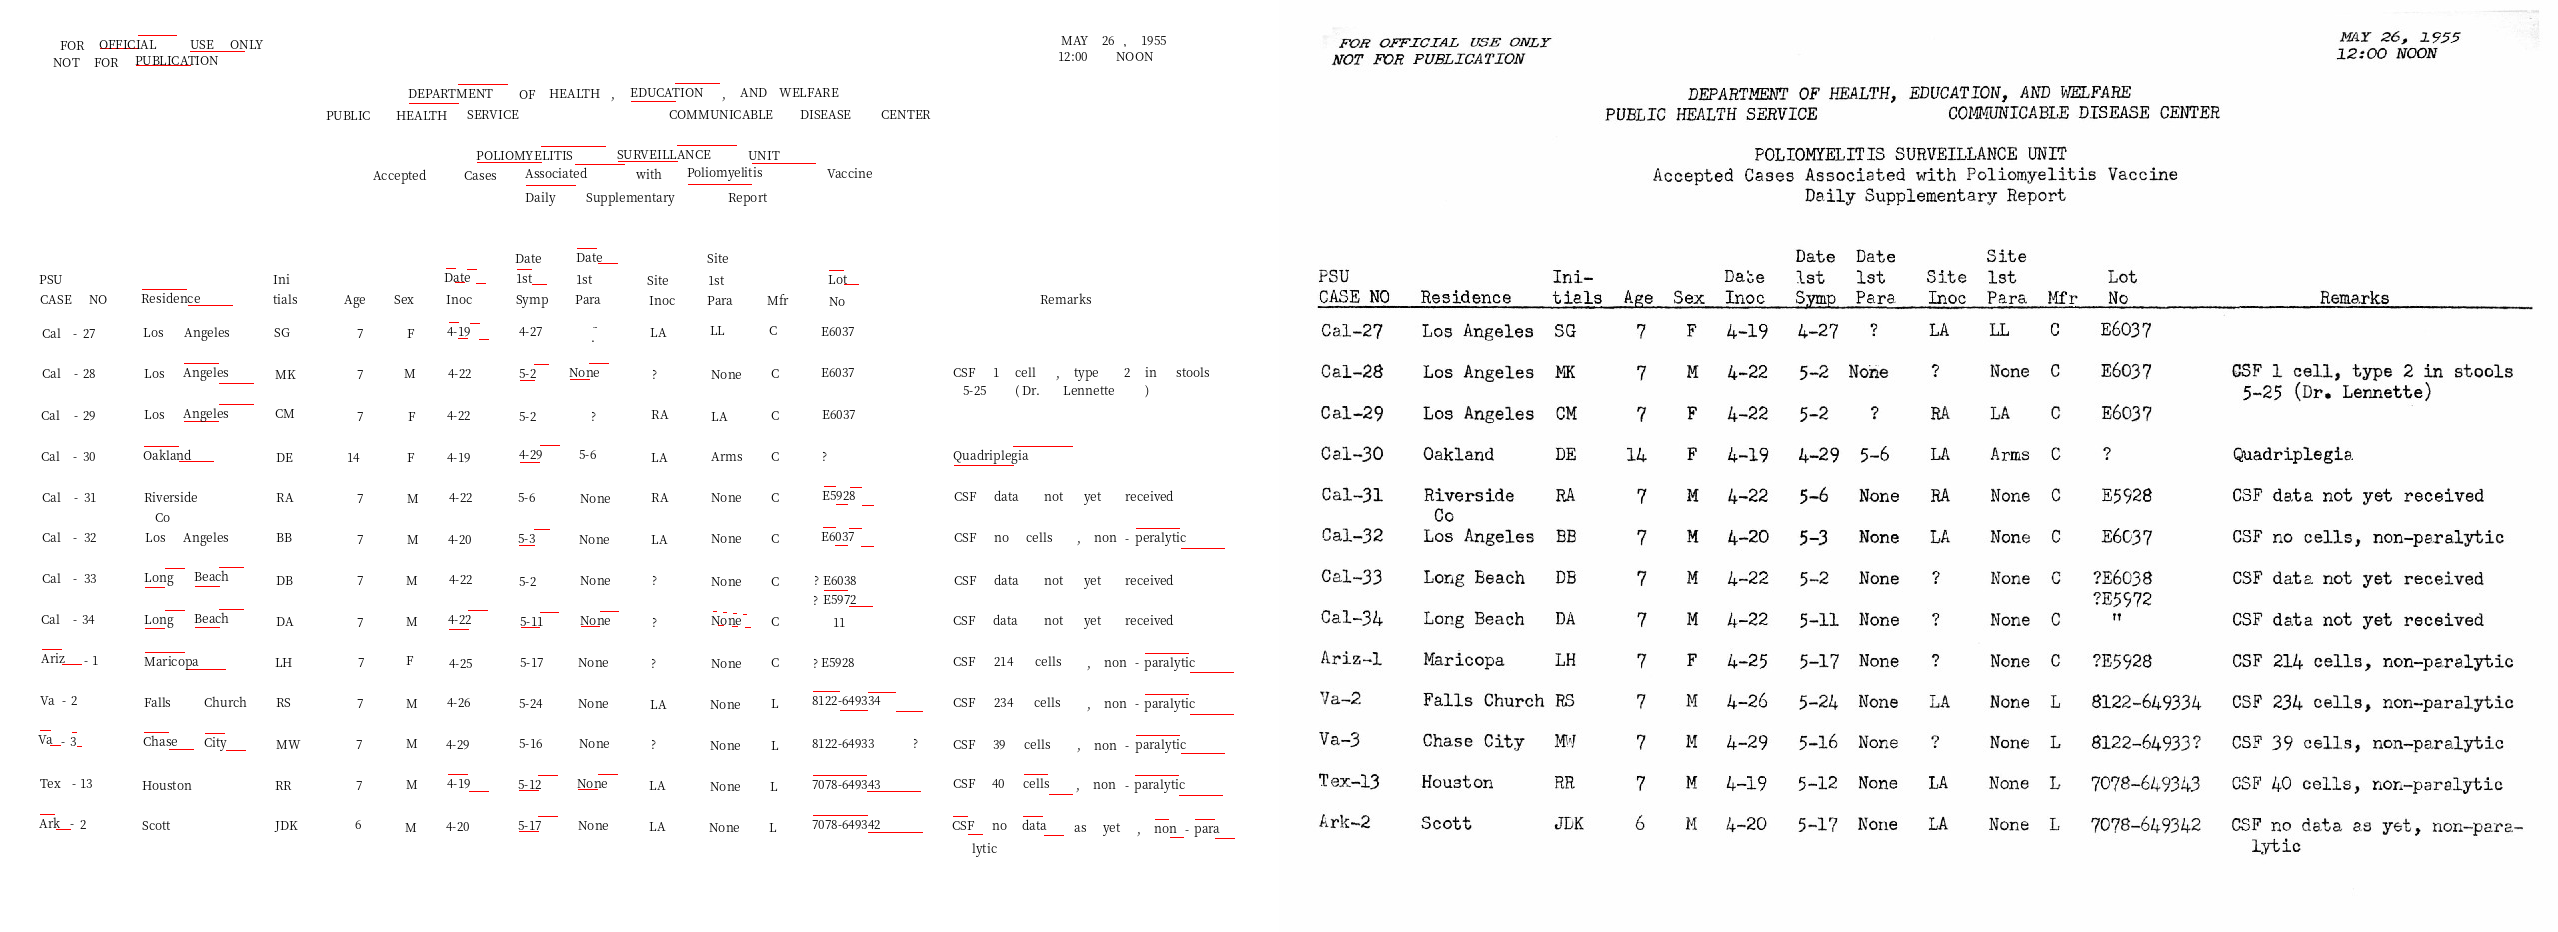

In [38]:
lp.draw_text(image, layout, font_size=12, with_box_on_text=True,
             text_box_width=1)

# Get coordinates of desired area (using external tool such as GIMP)

In [45]:
x1=132
y1=300
x2=264
y2=840

# select desired area ("Residence")

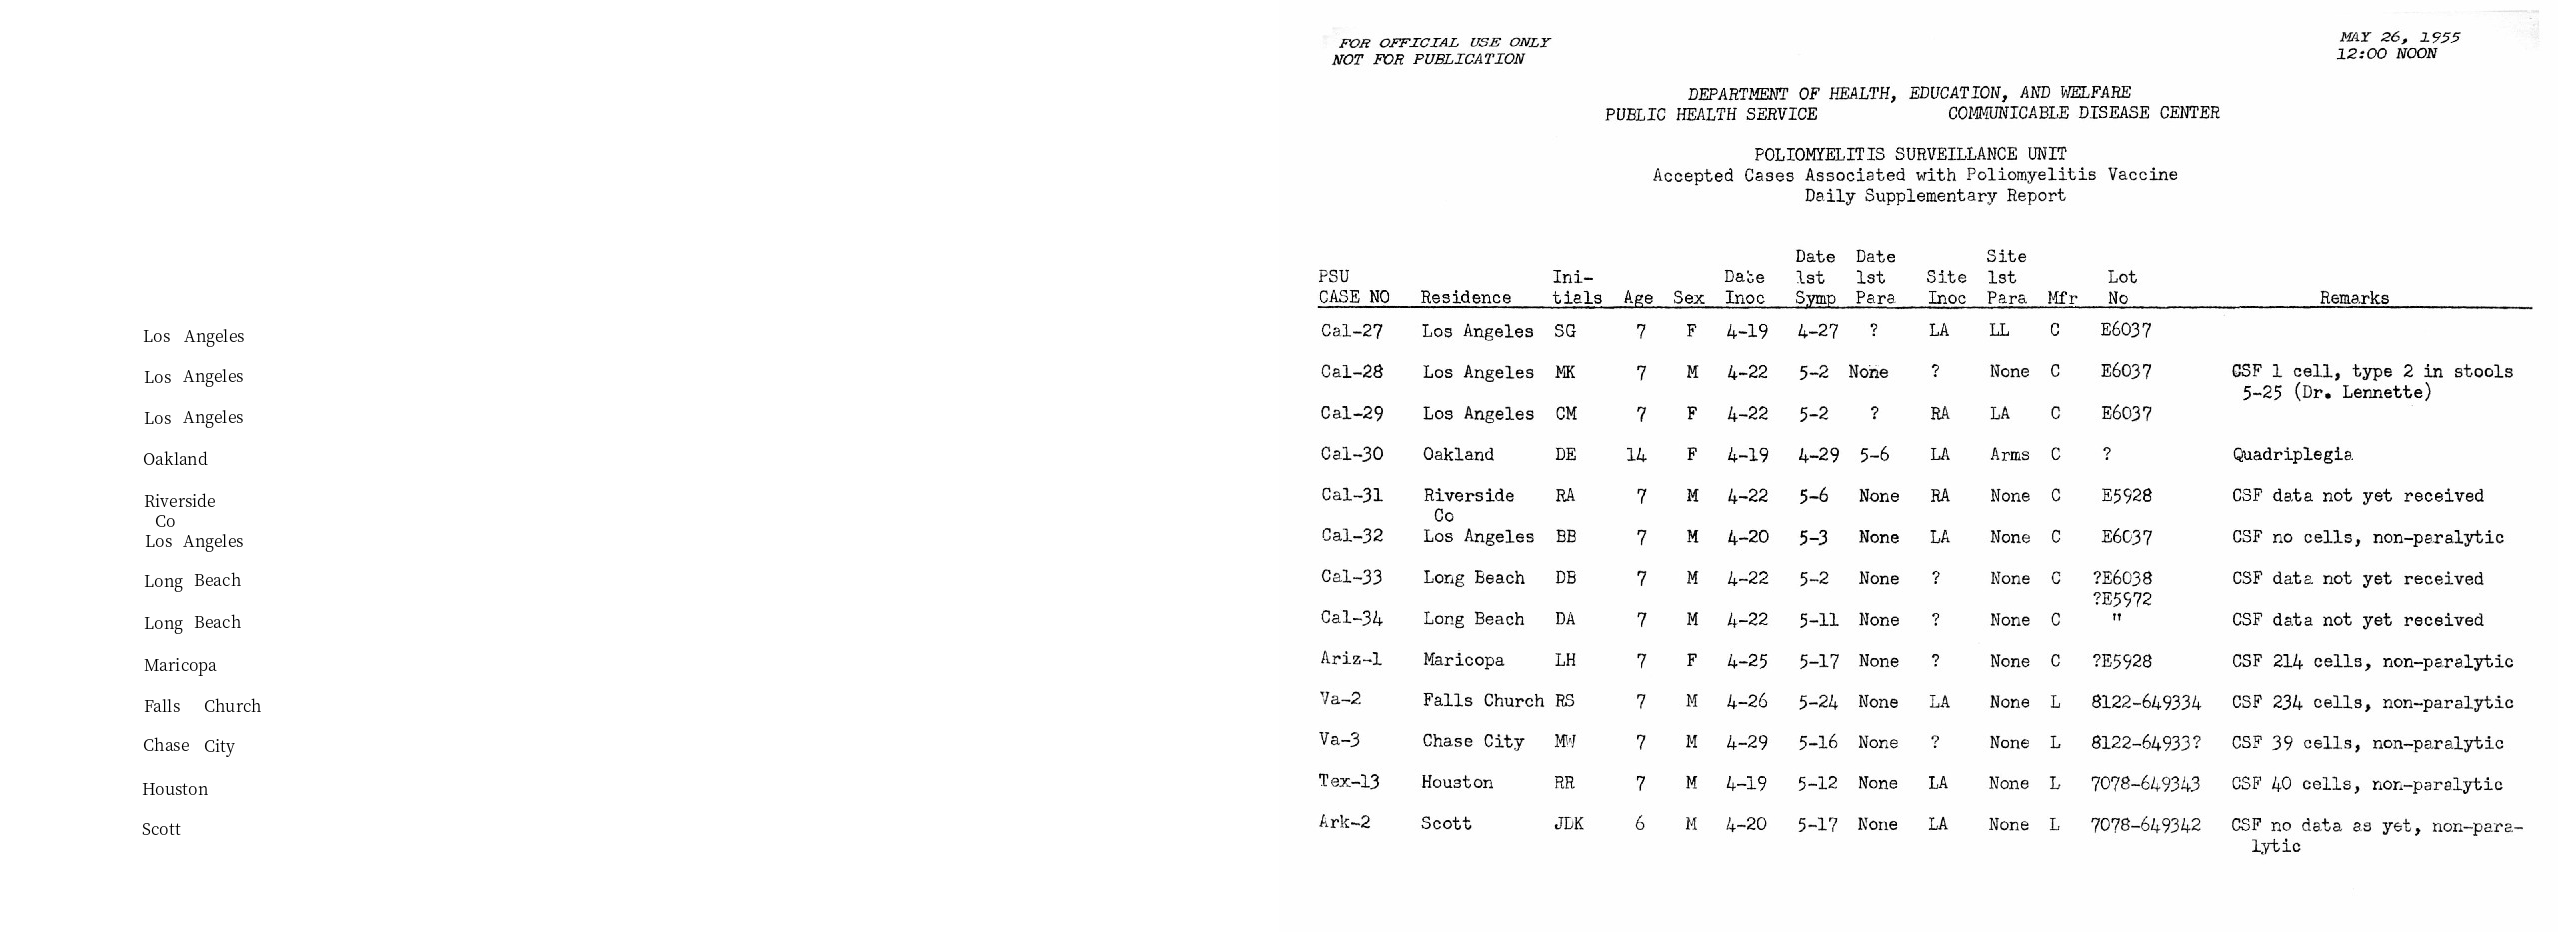

In [46]:
filtered_residence = layout.filter_by(lp.Rectangle(x_1=x1, y_1=y1, x_2=x2, y_2=y2))
lp.draw_text(image, filtered_residence, font_size=16)

# select another area with soft margin arg

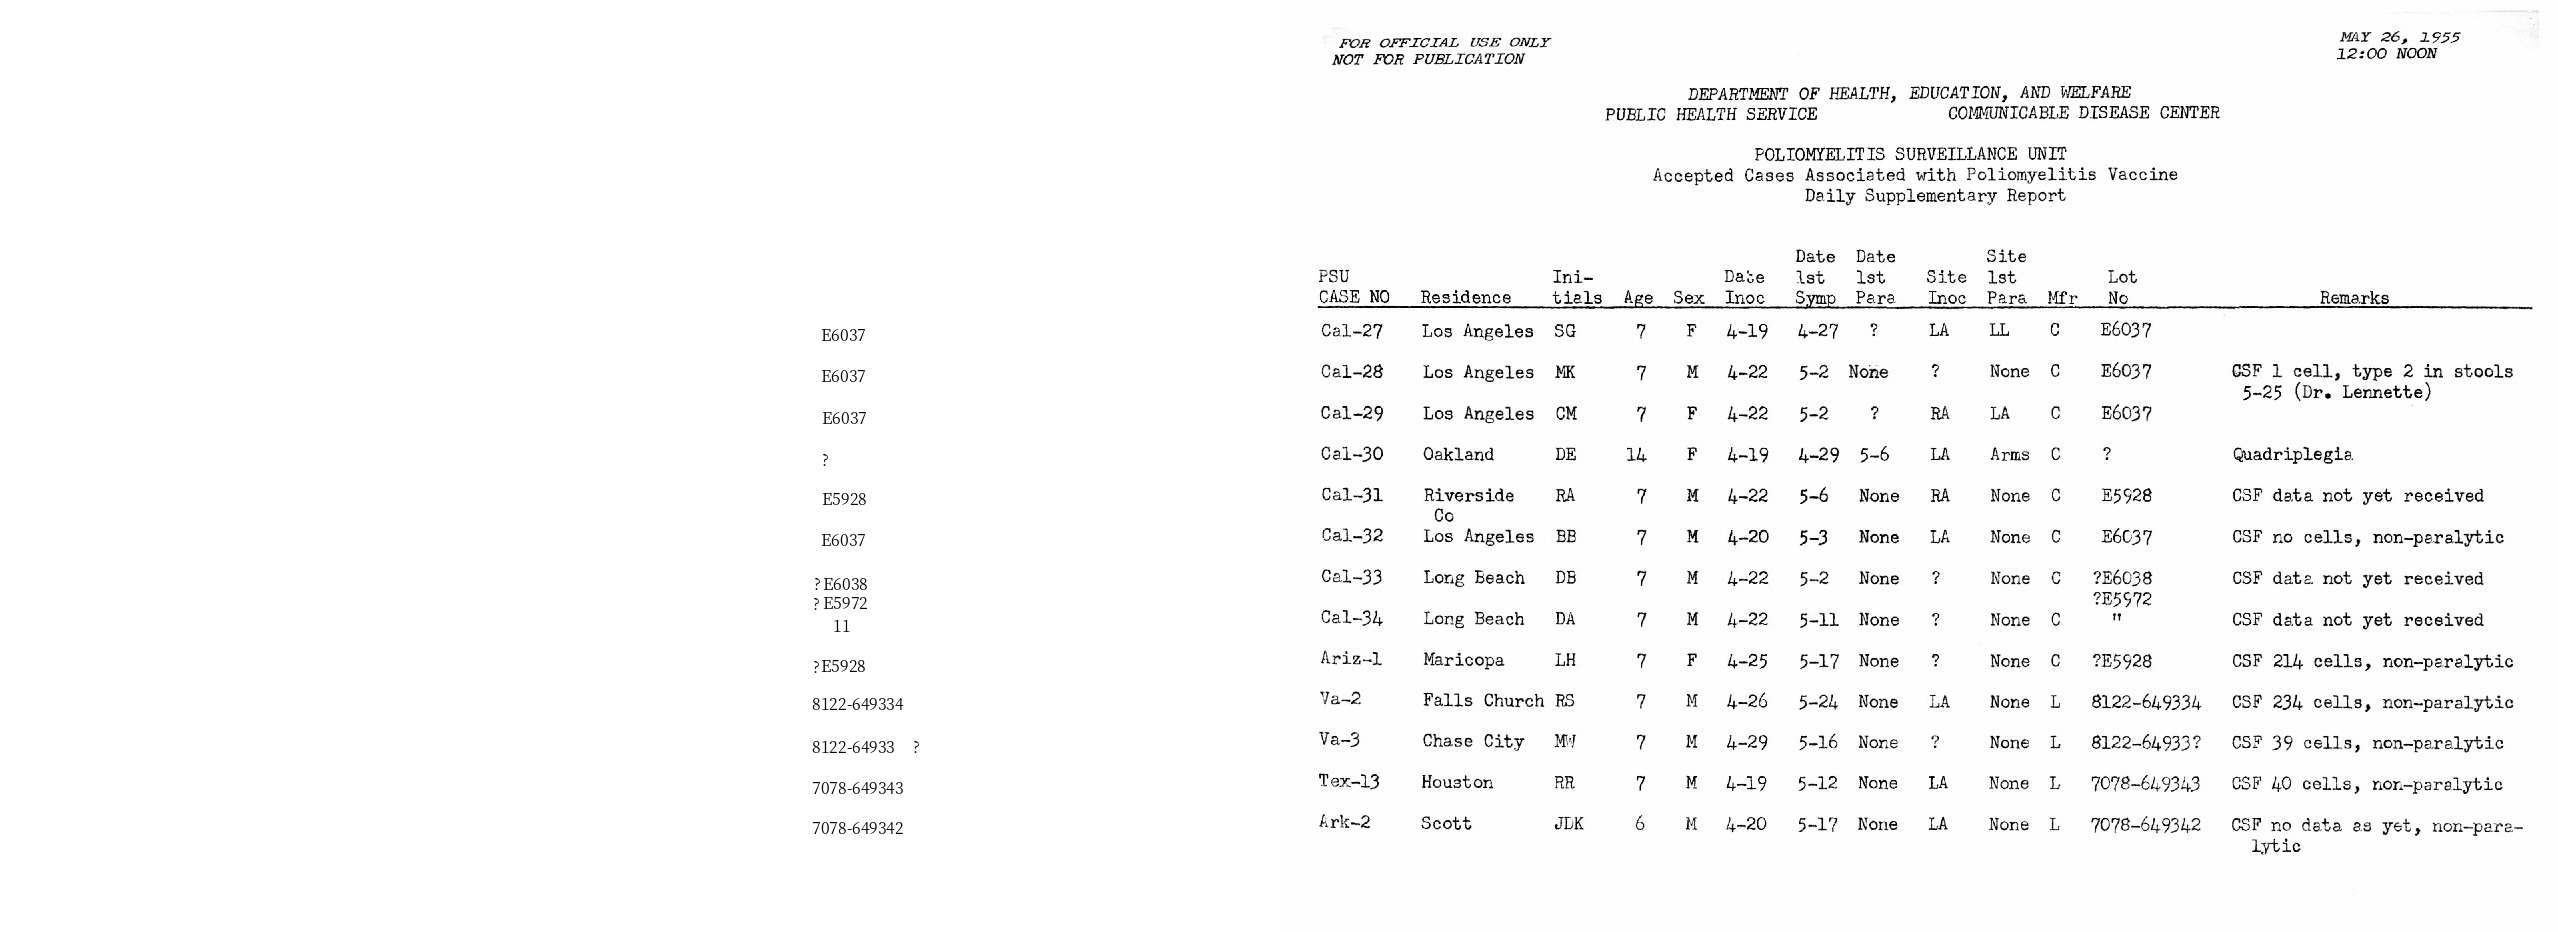

In [51]:
filtered_lotno = layout.filter_by(
    lp.Rectangle(x_1=810, y_1=300, x_2=910, y_2=840),
    soft_margin = {"left":10, "right":20} # Without it, the last 4 rows could not be included
)
lp.draw_text(image, filtered_lotno, font_size=16)

# group two areas into rows (alt 1: hard-code coordinates)

In [53]:
y_0 = 307
y_1 = 840
n_rows = 13
height = int((y_1 - y_0) / n_rows)

row = []
for y in range(y_0, y_1, height):

    interval = lp.Interval(y,y+height, axis='y')
    residence_row = filtered_residence.\
        filter_by(interval).\
        get_texts()

    lotno_row = filtered_lotno.\
        filter_by(interval).\
        get_texts()

    row.append([''.join(residence_row), ''.join(lotno_row)])

row

[['LosAngeles', 'E6037'],
 ['LosAngeles', 'E6037'],
 ['LosAngeles', 'E6037'],
 ['Oakland', '?'],
 ['Riverside', 'E5928'],
 ['LosAngeles', 'E6037'],
 ['LongBeach', '?E6038'],
 ['LongBeach', '11'],
 ['Maricopa', '?E5928'],
 ['FallsChurch', '8122-649334'],
 ['ChaseCity', '8122-64933?'],
 ['Houston', '7078-649343'],
 ['Scott', '7078-649342']]

# group two areas into one (alt 2: using distances)

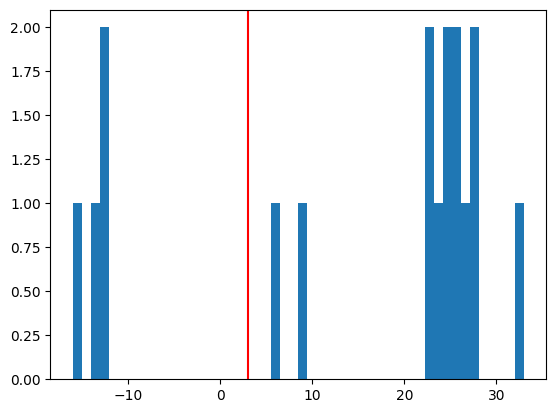

In [63]:
blocks = filtered_lotno
blocks = sorted(blocks, key = lambda x: x.coordinates[1])  # sort by coordinate of upper left corner 
    # also convert laout to list of blocks

distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])
    # Calculate the distances:
    # y coord for the upper edge of the bottom block -
    #   y coord for the bottom edge of the upper block
    # And convert to np array for easier post processing
plt.hist(distances, bins=50);
plt.axvline(x=3, color='r');
# negative value implicates multiple blocks in same row, same line (to the left)
# small value implicates multiple blocks in same row, different line (to the right)
# larger value implicates different rows

In [75]:
distance_th = 0

distances = np.append([0], distances) # Append a placeholder for the first word
block_group = (distances>distance_th).cumsum() # Create a block_group based on the distance threshold

block_group

array([ 0,  1,  2,  3,  4,  5,  6,  6,  7,  7,  8,  9,  9, 10, 11, 11, 12,
       13])

In [ ]:
# Group the blocks by the block_group mask
grouped_blocks = [[] for i in range(max(block_group)+1)]
for i, block in zip(block_group, blocks):
    grouped_blocks[i].append(block)
grouped_blocks

In [78]:
# function to group blocks by distance
def group_blocks_by_distance(blocks, distance_th):

    blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])

    distances = np.append([0], distances)
    block_group = (distances>distance_th).cumsum()

    grouped_blocks = [lp.Layout([]) for i in range(max(block_group)+1)]
    for i, block in zip(block_group, blocks):
        grouped_blocks[i].append(block)

    return grouped_blocks

In [79]:
A = group_blocks_by_distance(filtered_residence, 5)
B = group_blocks_by_distance(filtered_lotno, 10)

# And finally we combine the outputs
height_th = 30
idxA, idxB = 0, 0

result = []
while idxA < len(A) and idxB < len(B):
    ay = A[idxA][0].coordinates[1]
    by = B[idxB][0].coordinates[1]
    ares, bres = ''.join(A[idxA].get_texts()), ''.join(B[idxB].get_texts())
    if abs(ay - by) < height_th:
        idxA += 1; idxB += 1
    elif ay < by:
        idxA += 1; bres = ''
    else:
        idxB += 1; ares = ''
    result.append([ares, bres])

result

[['LosAngeles', 'E6037'],
 ['AngelesLos', 'E6037'],
 ['AngelesLos', 'E6037'],
 ['Oakland', '?'],
 ['Riverside', 'E5928'],
 ['Co', 'E6037'],
 ['LosAngeles', ''],
 ['BeachLong', '?E6038E5972?11'],
 ['BeachLong', ''],
 ['Maricopa', 'E5928?'],
 ['FallsChurch', '8122-649334'],
 ['ChaseCity', '8122-64933?'],
 ['Houston', '7078-649343'],
 ['Scott', '7078-649342']]

In [80]:
df = pd.DataFrame(row, columns=['residence', 'lot no'])
df

,residence,lot no
0,LosAngeles,E6037
1,LosAngeles,E6037
2,LosAngeles,E6037
3,Oakland,?
4,Riverside,E5928
5,LosAngeles,E6037
6,LongBeach,?E6038
7,LongBeach,11
8,Maricopa,?E5928
9,FallsChurch,8122-649334
